#### Introduction
This is a machine learning project to predict unit/property monthly rent price in Kuala Lumpur region, Malaysia. The project uses a dataset from an online ads listing for property mudah.my. This project outlines the process of web-scraping/ data gathering, data cleaning-wrangling, and machine learning modeling.

This project aims to answers question about how much a unit monthly rent would be if given information such as location, number of bedrooms, parking, furnished, etc? This would help potential tenant and also the owner to get the best price of their rental unit, comparable to the market value.

Some previous work about house pricing was listed below, however most of them are targeting a dataset of house pricing or an Airbnb pricing. There are difference such as in Airbnb, the booking rarely took more than 2 weeks, let alone a year. Therefore the pricing may be different. Additionally, in Airbnb, there is text feature coming from the review given by the tenant and the owner.The better the review, the higher the rent prices -- which was not available in this current project dataset.

Previous work by [@madhuri2019], [@xu2022], [@zhao2022] highlight the importance feature selection, and the choice of machine learning model. Based on the previous works, the most consistently performed machine learning model are Random Forest and Gradient boosting, and the MAE and R2 score usually used in evaluating the performance of the model. Although the above work are all not about apartment rent pricing, similar method can be applied to this project.

The following feature is available in the dataset:

ads_id: ads listing ID, unique to each ads
prop_name: the building name of the property
completion_year: year of the building/property completed
monthly_rent: monthly rent price in Malaysian Ringgit (RM)
location: the location (region) of the property
property_type: property type, such as flat, apartment, etc
rooms: number of rooms
parking: number of parking spot
bathroom: number of bathroom
size: total area of the unit in sq.ft
furnished: furnishin status of the unit, fully-partial-non
facilities: main facilities within the unit
additional_facilities: additional facilities

In [1]:
import polars as pl
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#### Data Understanding
Reload the original dataset.

In [2]:
file_path = "./mudah-apartment-kl-selangor.csv"

In [3]:
df = pl.read_csv(file_path, infer_schema_length=10000) 

In [4]:
df

ads_id,prop_name,completion_year,monthly_rent,location,property_type,rooms,parking,bathroom,size,furnished,facilities,additional_facilities,region
i64,str,f64,str,str,str,str,f64,f64,str,str,str,str,str
100323185,"""The Hipster @ …",2022.0,"""RM 4 200 per m…","""Kuala Lumpur -…","""Condominium""","""5""",2.0,6.0,"""1842 sq.ft.""","""Fully Furnishe…","""Minimart, Gymn…","""Air-Cond, Cook…","""Kuala Lumpur"""
100203973,"""Segar Courts""",null,"""RM 2 300 per m…","""Kuala Lumpur -…","""Condominium""","""3""",1.0,2.0,"""1170 sq.ft.""","""Partially Furn…","""Playground, Pa…","""Air-Cond, Cook…","""Kuala Lumpur"""
100323128,"""Pangsapuri Ter…",null,"""RM 1 000 per m…","""Kuala Lumpur -…","""Apartment""","""3""",null,2.0,"""650 sq.ft.""","""Fully Furnishe…","""Minimart, Jogg…",null,"""Kuala Lumpur"""
100191767,"""Sentul Point S…",2020.0,"""RM 1 700 per m…","""Kuala Lumpur -…","""Apartment""","""2""",1.0,2.0,"""743 sq.ft.""","""Partially Furn…","""Parking, Playg…","""Cooking Allowe…","""Kuala Lumpur"""
97022692,"""Arte Mont Kiar…",null,"""RM 1 299 per m…","""Kuala Lumpur -…","""Service Reside…","""1""",1.0,1.0,"""494 sq.ft.""","""Not Furnished""","""Parking, Secur…","""Air-Cond""","""Kuala Lumpur"""
100322897,"""Residensi Vist…",null,"""RM 1 500 per m…","""Kuala Lumpur -…","""Apartment""","""3""",1.0,2.0,"""884 sq.ft.""","""Partially Furn…","""Parking, Secur…","""Cooking Allowe…","""Kuala Lumpur"""
100322962,"""Sky Meridien""",null,"""RM 2 900 per m…","""Kuala Lumpur -…","""Service Reside…","""3""",2.0,2.0,"""982 sq.ft.""","""Fully Furnishe…","""Parking, Secur…","""Air-Cond, Cook…","""Kuala Lumpur"""
100322885,"""Arte Plus Jala…",2018.0,"""RM 1 550 per m…","""Kuala Lumpur -…","""Service Reside…","""1""",1.0,1.0,"""700 sq.ft.""","""Fully Furnishe…","""Parking, Gymna…","""Air-Cond, Cook…","""Kuala Lumpur"""
100322866,"""Nova I""",2014.0,"""RM 1 400 per m…","""Kuala Lumpur -…","""Apartment""","""2""",1.0,1.0,"""750 sq.ft.""","""Fully Furnishe…","""Playground, Se…","""Air-Cond, Cook…","""Kuala Lumpur"""


##### Data Description

In [5]:
df.describe()

describe,ads_id,prop_name,completion_year,monthly_rent,location,property_type,rooms,parking,bathroom,size,furnished,facilities,additional_facilities,region
str,f64,str,f64,str,str,str,str,f64,f64,str,str,str,str,str
"""count""",19991.0,"""19991""",19991.0,"""19991""","""19991""","""19991""","""19991""",19991.0,19991.0,"""19991""","""19991""","""19991""","""19991""","""19991"""
"""null_count""",0.0,"""948""",9185.0,"""2""","""0""","""0""","""6""",5702.0,6.0,"""0""","""5""","""2209""","""5948""","""0"""
"""mean""",9.9707e7,null,2014.822321,null,null,null,null,1.416824,1.891719,null,null,null,null,null
"""std""",3.4826e6,null,6.735355,null,null,null,null,0.567368,0.556266,null,null,null,null,null
"""min""",1.6525511e7,"""1 Harmonis""",1977.0,"""RM 1 000 per m…","""Kuala Lumpur -…","""Apartment""","""1""",1.0,1.0,"""1 sq.ft.""","""Fully Furnishe…","""Barbeque area""",""", Air-Cond, Co…","""Kuala Lumpur"""
"""max""",1.00854617e8,"""wangsa maju se…",2025.0,"""RM 999 per mon…","""Selangor - Ulu…","""Townhouse Cond…","""More than 10""",10.0,8.0,"""99999999 sq.ft…","""Partially Furn…","""Tennis Court, …","""Washing Machin…","""Selangor"""
"""median""",1.00212678e8,null,2017.0,null,null,null,null,1.0,2.0,null,null,null,null,null


##### Only select house in Kuala Lumpur Region

##### Drop Duplicate

In [6]:
df.filter(df.is_duplicated())

ads_id,prop_name,completion_year,monthly_rent,location,property_type,rooms,parking,bathroom,size,furnished,facilities,additional_facilities,region
i64,str,f64,str,str,str,str,f64,f64,str,str,str,str,str
100828884,"""Saville @ Cher…",2019.0,"""RM 1 800 per m…","""Selangor - Che…","""Service Reside…","""2.0""",1.0,1.0,"""1367 sq.ft.""","""Fully Furnishe…","""Gymnasium, Squ…","""Air-Cond, Cook…","""Selangor"""
100828884,"""Saville @ Cher…",2019.0,"""RM 1 800 per m…","""Selangor - Che…","""Service Reside…","""2.0""",1.0,1.0,"""1367 sq.ft.""","""Fully Furnishe…","""Gymnasium, Squ…","""Air-Cond, Cook…","""Selangor"""
100822848,"""Taming Mutiara…",null,"""RM 1 200 per m…","""Selangor - Ban…","""Apartment""","""3.0""",2.0,2.0,"""986 sq.ft.""","""Fully Furnishe…","""Parking, Secur…","""Cooking Allowe…","""Selangor"""
100822848,"""Taming Mutiara…",null,"""RM 1 200 per m…","""Selangor - Ban…","""Apartment""","""3.0""",2.0,2.0,"""986 sq.ft.""","""Fully Furnishe…","""Parking, Secur…","""Cooking Allowe…","""Selangor"""
100800319,"""Greenfield Res…",2021.0,"""RM 1 500 per m…","""Selangor - Ban…","""Service Reside…","""2.0""",1.0,1.0,"""581 sq.ft.""","""Partially Furn…","""Jogging Track,…","""Air-Cond, Cook…","""Selangor"""
100800319,"""Greenfield Res…",2021.0,"""RM 1 500 per m…","""Selangor - Ban…","""Service Reside…","""2.0""",1.0,1.0,"""581 sq.ft.""","""Partially Furn…","""Jogging Track,…","""Air-Cond, Cook…","""Selangor"""
100786964,"""Desa Saujana""",null,"""RM 900 per mon…","""Selangor - Ser…","""Apartment""","""3.0""",1.0,2.0,"""850 sq.ft.""","""Fully Furnishe…","""Parking, Gymna…","""Cooking Allowe…","""Selangor"""
100786964,"""Desa Saujana""",null,"""RM 900 per mon…","""Selangor - Ser…","""Apartment""","""3.0""",1.0,2.0,"""850 sq.ft.""","""Fully Furnishe…","""Parking, Gymna…","""Cooking Allowe…","""Selangor"""
100691270,"""Sri Sunway Apa…",2002.0,"""RM 950 per mon…","""Selangor - Puc…","""Apartment""","""3.0""",1.0,2.0,"""823 sq.ft.""","""Partially Furn…","""Security, Play…","""Air-Cond, Cook…","""Selangor"""


In [7]:
df = df.unique()

##### Extracting Number and Keyword

In [8]:
df = df.with_columns(pl.col("monthly_rent").apply(lambda x: int(re.search(r'RM (.*?) per', x).group(1).replace(' ', ''))))
df = df.rename({"monthly_rent": "monthly_rent_rm"})

In [9]:
df = df.with_columns(pl.col("size").apply(lambda x: int(re.search(r'(.*?) sq', x).group(1).replace(' ', ''))))
df = df.rename({'size': 'size_sqft'})

In [10]:
df = df.with_columns(pl.col("location").apply(lambda x: re.sub(r"Kuala Lumpur - \s*", "", x)))

In [11]:
df = df.with_columns(pl.col("location").apply(lambda x: re.sub(r"Selangor - \s*", "", x)))

In [12]:
df

ads_id,prop_name,completion_year,monthly_rent_rm,location,property_type,rooms,parking,bathroom,size_sqft,furnished,facilities,additional_facilities,region
i64,str,f64,i64,str,str,str,f64,f64,i64,str,str,str,str
99258931,"""The Arc @ Cybe…",null,1100,"""Cyberjaya""","""Service Reside…","""3.0""",1.0,2.0,913,"""Partially Furn…","""Parking, Gymna…","""Washing Machin…","""Selangor"""
100291588,"""Rampai Court""",null,1000,"""Wangsa Maju""","""Apartment""","""2""",1.0,1.0,600,"""Not Furnished""","""Parking, Barbe…","""Cooking Allowe…","""Kuala Lumpur"""
99816812,"""South View""",2017.0,3200,"""Bangsar South""","""Service Reside…","""3""",1.0,2.0,990,"""Fully Furnishe…","""Multipurpose h…","""Air-Cond, Cook…","""Kuala Lumpur"""
99662512,"""Panorama Resid…",2014.0,1800,"""Sentul""","""Condominium""","""3""",1.0,2.0,1100,"""Fully Furnishe…","""Minimart, Swim…",null,"""Kuala Lumpur"""
100307684,"""Impiana Sky Re…",2021.0,1300,"""Bukit Jalil""","""Apartment""","""3""",1.0,2.0,850,"""Partially Furn…","""Playground, Mu…",null,"""Kuala Lumpur"""
100230519,"""Putra Villa""",2007.0,1800,"""Setapak""","""Condominium""","""3""",1.0,2.0,1076,"""Fully Furnishe…",null,null,"""Kuala Lumpur"""
99914291,"""Tuan Residency…",null,1400,"""Jalan Kuching""","""Service Reside…","""3""",1.0,2.0,878,"""Partially Furn…","""Swimming Pool,…","""Air-Cond, Cook…","""Kuala Lumpur"""
99763647,"""Sentul Utama C…",2009.0,1400,"""Sentul""","""Condominium""","""3""",1.0,2.0,900,"""Partially Furn…","""Parking, Secur…",null,"""Kuala Lumpur"""
99585840,"""Hyde Tower @ i…",2018.0,1200,"""Shah Alam""","""Service Reside…","""1.0""",1.0,1.0,500,"""Fully Furnishe…","""Parking, Secur…","""Air-Cond, Cook…","""Selangor"""


In [13]:
df.with_columns([pl.col("additional_facilities").str.lengths().alias("len")]).max().glimpse()

Rows: 1
Columns: 15
$ ads_id                <i64> 100854617
$ prop_name             <str> wangsa maju section 2
$ completion_year       <f64> 2025.0
$ monthly_rent_rm       <i64> 2400000
$ location              <str> Wangsa Maju
$ property_type         <str> Townhouse Condo
$ rooms                 <str> More than 10
$ parking               <f64> 10.0
$ bathroom              <f64> 8.0
$ size_sqft             <i64> 99999999
$ furnished             <str> Partially Furnished
$ facilities            <str> Tennis Court, Swimming Pool, Squash Court, Jogging Track, Gymnasium, Parking, Security, Minimart, Playground
$ additional_facilities <str> Washing Machine, Near KTM/LRT, Internet, Cooking Allowed
$ region                <str> Selangor
$ len                   <u32> 68



##### Extracting Near KTM/LRT
Hypotheses: closer access to KTM/LRT = higher monthly rent

In [14]:
df["additional_facilities"].apply(lambda x : str(x).replace(", ", ","))

additional_facilities
str
"""Washing Machin…"
"""Cooking Allowe…"
"""Air-Cond,Cooki…"
null
null
null
"""Air-Cond,Cooki…"
null
"""Air-Cond,Cooki…"


In [15]:
df = df.select([
    pl.all(),
    pl.col("additional_facilities").apply(lambda x : str(x).replace(", ", ",")).alias("additional_facilities_clean")
])

In [16]:
df

ads_id,prop_name,completion_year,monthly_rent_rm,location,property_type,rooms,parking,bathroom,size_sqft,furnished,facilities,additional_facilities,region,additional_facilities_clean
i64,str,f64,i64,str,str,str,f64,f64,i64,str,str,str,str,str
99258931,"""The Arc @ Cybe…",null,1100,"""Cyberjaya""","""Service Reside…","""3.0""",1.0,2.0,913,"""Partially Furn…","""Parking, Gymna…","""Washing Machin…","""Selangor""","""Washing Machin…"
100291588,"""Rampai Court""",null,1000,"""Wangsa Maju""","""Apartment""","""2""",1.0,1.0,600,"""Not Furnished""","""Parking, Barbe…","""Cooking Allowe…","""Kuala Lumpur""","""Cooking Allowe…"
99816812,"""South View""",2017.0,3200,"""Bangsar South""","""Service Reside…","""3""",1.0,2.0,990,"""Fully Furnishe…","""Multipurpose h…","""Air-Cond, Cook…","""Kuala Lumpur""","""Air-Cond,Cooki…"
99662512,"""Panorama Resid…",2014.0,1800,"""Sentul""","""Condominium""","""3""",1.0,2.0,1100,"""Fully Furnishe…","""Minimart, Swim…",null,"""Kuala Lumpur""",null
100307684,"""Impiana Sky Re…",2021.0,1300,"""Bukit Jalil""","""Apartment""","""3""",1.0,2.0,850,"""Partially Furn…","""Playground, Mu…",null,"""Kuala Lumpur""",null
100230519,"""Putra Villa""",2007.0,1800,"""Setapak""","""Condominium""","""3""",1.0,2.0,1076,"""Fully Furnishe…",null,null,"""Kuala Lumpur""",null
99914291,"""Tuan Residency…",null,1400,"""Jalan Kuching""","""Service Reside…","""3""",1.0,2.0,878,"""Partially Furn…","""Swimming Pool,…","""Air-Cond, Cook…","""Kuala Lumpur""","""Air-Cond,Cooki…"
99763647,"""Sentul Utama C…",2009.0,1400,"""Sentul""","""Condominium""","""3""",1.0,2.0,900,"""Partially Furn…","""Parking, Secur…",null,"""Kuala Lumpur""",null
99585840,"""Hyde Tower @ i…",2018.0,1200,"""Shah Alam""","""Service Reside…","""1.0""",1.0,1.0,500,"""Fully Furnishe…","""Parking, Secur…","""Air-Cond, Cook…","""Selangor""","""Air-Cond,Cooki…"


In [17]:
def extract_facilities(text: str, regex: str):
    pattern = re.compile(r'\b{}\b'.format(regex))
    try:
        match = pattern.search(text)
        if match:
            return True
        return False
    except TypeError:
        return text

In [18]:
def pipe_extract_facilities(df: pl.DataFrame, regex: str) -> pl.DataFrame:
    return df.select([pl.all(), pl.col("additional_facilities_clean").apply(lambda x: extract_facilities(x, regex)).alias(f"{regex}_availability")])

In [19]:
df = df.pipe(pipe_extract_facilities, "Air-Cond").pipe(pipe_extract_facilities, "Washing Machine").pipe(pipe_extract_facilities, "Near KTM/LRT").pipe(pipe_extract_facilities, "Internet").pipe(pipe_extract_facilities, "Cooking Allowed")

In [20]:
df

ads_id,prop_name,completion_year,monthly_rent_rm,location,property_type,rooms,parking,bathroom,size_sqft,furnished,facilities,additional_facilities,region,additional_facilities_clean,Air-Cond_availability,Washing Machine_availability,Near KTM/LRT_availability,Internet_availability,Cooking Allowed_availability
i64,str,f64,i64,str,str,str,f64,f64,i64,str,str,str,str,str,bool,bool,bool,bool,bool
99258931,"""The Arc @ Cybe…",null,1100,"""Cyberjaya""","""Service Reside…","""3.0""",1.0,2.0,913,"""Partially Furn…","""Parking, Gymna…","""Washing Machin…","""Selangor""","""Washing Machin…",false,true,false,false,false
100291588,"""Rampai Court""",null,1000,"""Wangsa Maju""","""Apartment""","""2""",1.0,1.0,600,"""Not Furnished""","""Parking, Barbe…","""Cooking Allowe…","""Kuala Lumpur""","""Cooking Allowe…",false,false,false,false,true
99816812,"""South View""",2017.0,3200,"""Bangsar South""","""Service Reside…","""3""",1.0,2.0,990,"""Fully Furnishe…","""Multipurpose h…","""Air-Cond, Cook…","""Kuala Lumpur""","""Air-Cond,Cooki…",true,true,false,false,true
99662512,"""Panorama Resid…",2014.0,1800,"""Sentul""","""Condominium""","""3""",1.0,2.0,1100,"""Fully Furnishe…","""Minimart, Swim…",null,"""Kuala Lumpur""",null,null,null,null,null,null
100307684,"""Impiana Sky Re…",2021.0,1300,"""Bukit Jalil""","""Apartment""","""3""",1.0,2.0,850,"""Partially Furn…","""Playground, Mu…",null,"""Kuala Lumpur""",null,null,null,null,null,null
100230519,"""Putra Villa""",2007.0,1800,"""Setapak""","""Condominium""","""3""",1.0,2.0,1076,"""Fully Furnishe…",null,null,"""Kuala Lumpur""",null,null,null,null,null,null
99914291,"""Tuan Residency…",null,1400,"""Jalan Kuching""","""Service Reside…","""3""",1.0,2.0,878,"""Partially Furn…","""Swimming Pool,…","""Air-Cond, Cook…","""Kuala Lumpur""","""Air-Cond,Cooki…",true,false,false,false,true
99763647,"""Sentul Utama C…",2009.0,1400,"""Sentul""","""Condominium""","""3""",1.0,2.0,900,"""Partially Furn…","""Parking, Secur…",null,"""Kuala Lumpur""",null,null,null,null,null,null
99585840,"""Hyde Tower @ i…",2018.0,1200,"""Shah Alam""","""Service Reside…","""1.0""",1.0,1.0,500,"""Fully Furnishe…","""Parking, Secur…","""Air-Cond, Cook…","""Selangor""","""Air-Cond,Cooki…",true,true,true,true,true


In [21]:
#Air-Cond_availability	Washing Machine_availability	Near KTM/LRT_availability	Internet_availability	Cooking Allowed_availability

aircond_available = df.filter(pl.col("Air-Cond_availability") == True).select(pl.col("monthly_rent_rm")).median().item()
no_aircond_available = df.filter(pl.col("Air-Cond_availability") == False).select(pl.col("monthly_rent_rm")).median().item()
washing_machine_available = df.filter(pl.col("Washing Machine_availability") == True).select(pl.col("monthly_rent_rm")).median().item()
no_washing_machine_available = df.filter(pl.col("Washing Machine_availability") == False).select(pl.col("monthly_rent_rm")).median().item()
near_ktmlrt = df.filter(pl.col("Near KTM/LRT_availability") == True).select(pl.col("monthly_rent_rm")).median().item()
not_near_ktmlrt = df.filter(pl.col("Near KTM/LRT_availability") == False).select(pl.col("monthly_rent_rm")).median().item()
internet_available = df.filter(pl.col("Internet_availability") == True).select(pl.col("monthly_rent_rm")).median().item()
no_internet_available = df.filter(pl.col("Internet_availability") == False).select(pl.col("monthly_rent_rm")).median().item()
cooking_allowed = df.filter(pl.col("Cooking Allowed_availability") == True).select(pl.col("monthly_rent_rm")).median().item()
no_cooking_allowed = df.filter(pl.col("Cooking Allowed_availability") == False).select(pl.col("monthly_rent_rm")).median().item()

In [22]:
f"""
Median:
Aircond Available: {aircond_available:.0f} RM
No Aircond Available: {no_aircond_available:.0f} RM
Washing Machine Available: {washing_machine_available:.0f} RM
No Washing Machine Available: {no_washing_machine_available:.0f} RM
Nearby KTM/LRT: {near_ktmlrt:.0f} RM
Not nearby KTM/LRT: {not_near_ktmlrt:.0f} RM
Internet Available: {internet_available:.0f} RM
No Internet Available: {no_internet_available:.0f} RM
Cooking Allowed: {cooking_allowed:.0f} RM
No Cooking Allowed: {no_cooking_allowed:.0f} RM
"""

'\nMedian:\nAircond Available: 1600 RM\nNo Aircond Available: 1000 RM\nWashing Machine Available: 1693 RM\nNo Washing Machine Available: 1250 RM\nNearby KTM/LRT: 1500 RM\nNot nearby KTM/LRT: 1400 RM\nInternet Available: 1500 RM\nNo Internet Available: 1400 RM\nCooking Allowed: 1500 RM\nNo Cooking Allowed: 1300 RM\n'

#### 
Plotting the difference between nearby KTM/LRT or not:

(0.0, 4000.0)

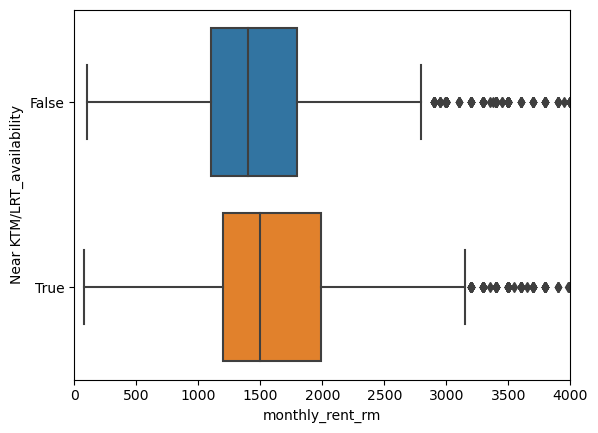

In [23]:
#| label: fig-nearbyktm
#| fig-cap: Boxplot between Nearby KTM/LRT or Not

sns.boxplot(data=df.to_pandas(), x='monthly_rent_rm', y='Near KTM/LRT_availability')
plt.xlim(0,4000)

In [24]:
df

ads_id,prop_name,completion_year,monthly_rent_rm,location,property_type,rooms,parking,bathroom,size_sqft,furnished,facilities,additional_facilities,region,additional_facilities_clean,Air-Cond_availability,Washing Machine_availability,Near KTM/LRT_availability,Internet_availability,Cooking Allowed_availability
i64,str,f64,i64,str,str,str,f64,f64,i64,str,str,str,str,str,bool,bool,bool,bool,bool
99258931,"""The Arc @ Cybe…",null,1100,"""Cyberjaya""","""Service Reside…","""3.0""",1.0,2.0,913,"""Partially Furn…","""Parking, Gymna…","""Washing Machin…","""Selangor""","""Washing Machin…",false,true,false,false,false
100291588,"""Rampai Court""",null,1000,"""Wangsa Maju""","""Apartment""","""2""",1.0,1.0,600,"""Not Furnished""","""Parking, Barbe…","""Cooking Allowe…","""Kuala Lumpur""","""Cooking Allowe…",false,false,false,false,true
99816812,"""South View""",2017.0,3200,"""Bangsar South""","""Service Reside…","""3""",1.0,2.0,990,"""Fully Furnishe…","""Multipurpose h…","""Air-Cond, Cook…","""Kuala Lumpur""","""Air-Cond,Cooki…",true,true,false,false,true
99662512,"""Panorama Resid…",2014.0,1800,"""Sentul""","""Condominium""","""3""",1.0,2.0,1100,"""Fully Furnishe…","""Minimart, Swim…",null,"""Kuala Lumpur""",null,null,null,null,null,null
100307684,"""Impiana Sky Re…",2021.0,1300,"""Bukit Jalil""","""Apartment""","""3""",1.0,2.0,850,"""Partially Furn…","""Playground, Mu…",null,"""Kuala Lumpur""",null,null,null,null,null,null
100230519,"""Putra Villa""",2007.0,1800,"""Setapak""","""Condominium""","""3""",1.0,2.0,1076,"""Fully Furnishe…",null,null,"""Kuala Lumpur""",null,null,null,null,null,null
99914291,"""Tuan Residency…",null,1400,"""Jalan Kuching""","""Service Reside…","""3""",1.0,2.0,878,"""Partially Furn…","""Swimming Pool,…","""Air-Cond, Cook…","""Kuala Lumpur""","""Air-Cond,Cooki…",true,false,false,false,true
99763647,"""Sentul Utama C…",2009.0,1400,"""Sentul""","""Condominium""","""3""",1.0,2.0,900,"""Partially Furn…","""Parking, Secur…",null,"""Kuala Lumpur""",null,null,null,null,null,null
99585840,"""Hyde Tower @ i…",2018.0,1200,"""Shah Alam""","""Service Reside…","""1.0""",1.0,1.0,500,"""Fully Furnishe…","""Parking, Secur…","""Air-Cond, Cook…","""Selangor""","""Air-Cond,Cooki…",true,true,true,true,true


In [25]:
df.filter(pl.col('prop_name') == 'Majestic Maxim')["Near KTM/LRT_availability"].value_counts()

Near KTM/LRT_availability,counts
bool,u32
null,32
false,24
true,166


####
As seen above, @fig-nearbyktm shows that it sligthly increases the median monthly rent by 50RM. However, near KTM/LRT is not appearing in all row even though the property is the same

Conclusion: Near KTM/LRT may be used, but it can be improved as the listing is inconsistent

##### Drop Missing Values in Facilities and Additional Facilities

In [26]:
df.select(pl.all().is_null()).sum()

ads_id,prop_name,completion_year,monthly_rent_rm,location,property_type,rooms,parking,bathroom,size_sqft,furnished,facilities,additional_facilities,region,additional_facilities_clean,Air-Cond_availability,Washing Machine_availability,Near KTM/LRT_availability,Internet_availability,Cooking Allowed_availability
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,948,9181,2,0,0,6,5699,6,0,5,2208,5945,0,5945,5945,5945,5945,5945,5945


In [27]:
# #dropping some columns
df = df.drop(['ads_id', 
    'prop_name', 
    'facilities', 
    'additional_facilities',
    'additional_facilities_clean'])

In [28]:
df.select(pl.col("rooms")).unique()

rooms
str
"""3"""
"""4.0"""
"""7.0"""
"""6.0"""
"""5"""
"""4"""
"""2.0"""
"""6"""
"""1"""


####
Converting rooms from object to int64

In [29]:
df = df.with_columns(pl.col("rooms").apply(lambda x: 10 if x == "More than 10" else x))

In [30]:
df = df.with_columns(pl.col("rooms").cast(pl.Float64))

In [31]:
df = df.with_columns(pl.col("rooms").cast(pl.Int64))

##### Outlier Removal
To remove some unexplainable data such as 0 monthly rent, 0 size, the rent that is way too old (1970), including the monthly rent that is way too high and/or size too big.

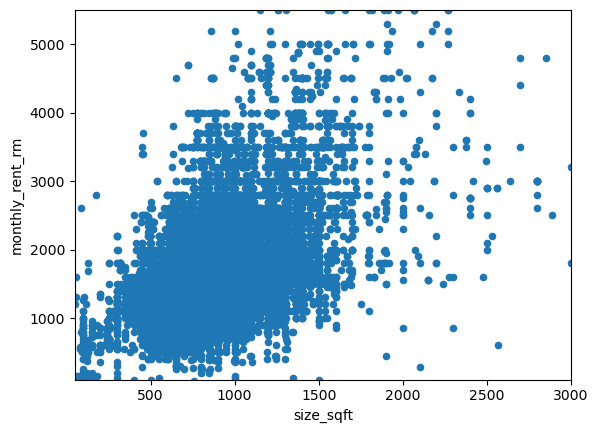

In [32]:
#| label: fig-size-rent
#| fig-cap: "Monthly Rent"
df.to_pandas()[['size_sqft', 'monthly_rent_rm']].plot(kind='scatter', x='size_sqft', y='monthly_rent_rm');
plt.ylim(100,5500)
plt.xlim(50,3000)
plt.show()

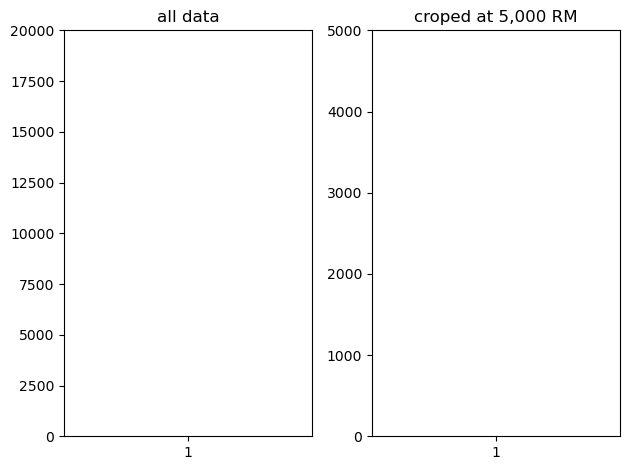

In [33]:
#| label: fig-compare-rent
#| fig-cap: "Comparison between Different Scale"
fig, axs = plt.subplots(1,2)
axs[0].boxplot(data=df.to_pandas(), x='monthly_rent_rm')
axs[0].set_ylim(0,20000)
axs[0].set_title('all data')

axs[1].boxplot(data=df.to_pandas(), x='monthly_rent_rm')
axs[1].set_ylim(0,5000)
axs[1].set_title('croped at 5,000 RM')

plt.tight_layout()
plt.show()

<Axes: title={'center': 'all data'}>

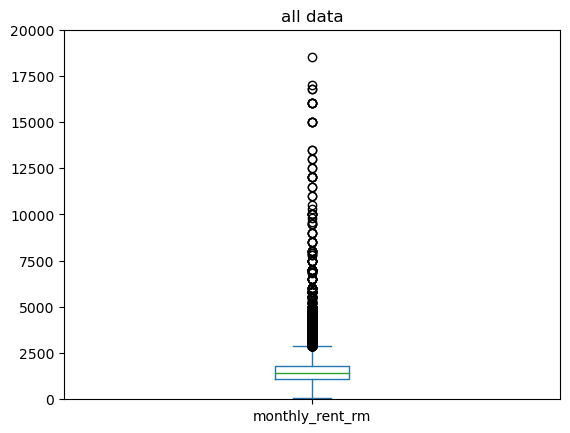

In [34]:
df.to_pandas()["monthly_rent_rm"].plot(kind="box", ylim = (0,20000), title='all data')

<Axes: title={'center': 'croped at 5,000 RM'}>

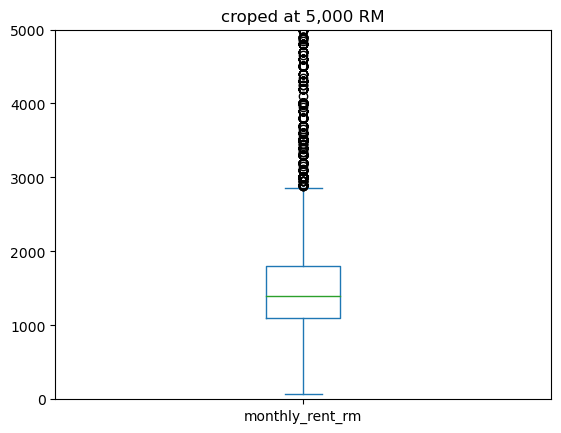

In [35]:
df.to_pandas()["monthly_rent_rm"].plot(kind="box", ylim = (0,5000), title='croped at 5,000 RM')

#### 
Based on EDA on @fig-size-rent and @fig-compare-rent, author decided to filter the data between 100-5500 RM as follows:

In [36]:
df.columns

['completion_year',
 'monthly_rent_rm',
 'location',
 'property_type',
 'rooms',
 'parking',
 'bathroom',
 'size_sqft',
 'furnished',
 'region',
 'Air-Cond_availability',
 'Washing Machine_availability',
 'Near KTM/LRT_availability',
 'Internet_availability',
 'Cooking Allowed_availability']

In [37]:
# removing all rows with monthly rent above 5500 RM and below 100RM
dfx = df.filter((pl.col("monthly_rent_rm") > 100) & (pl.col("monthly_rent_rm") < 5500))

In [38]:
dfx.describe()

describe,completion_year,monthly_rent_rm,location,property_type,rooms,parking,bathroom,size_sqft,furnished,region,Air-Cond_availability,Washing Machine_availability,Near KTM/LRT_availability,Internet_availability,Cooking Allowed_availability
str,f64,f64,str,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64
"""count""",19800.0,19800.0,"""19800""","""19800""",19800.0,19800.0,19800.0,19800.0,"""19800""","""19800""",19800.0,19800.0,19800.0,19800.0,19800.0
"""null_count""",9101.0,0.0,"""0""","""0""",6.0,5655.0,4.0,0.0,"""1""","""0""",5879.0,5879.0,5879.0,5879.0,5879.0
"""mean""",2014.851388,1564.744545,null,null,2.672375,1.411241,1.87841,5960.486768,null,null,0.767761,0.532936,0.534444,0.176927,0.914518
"""std""",6.742338,710.937121,null,null,0.797813,0.561088,0.518821,710662.728891,null,null,0.422276,0.498934,0.498828,0.381621,0.27961
"""min""",1977.0,110.0,"""360""","""Apartment""",1.0,1.0,1.0,1.0,"""Fully Furnishe…","""Kuala Lumpur""",0.0,0.0,0.0,0.0,0.0
"""max""",2025.0,5499.0,"""Wangsa Maju""","""Townhouse Cond…",10.0,10.0,8.0,9.9999999e7,"""Partially Furn…","""Selangor""",1.0,1.0,1.0,1.0,1.0
"""median""",2017.0,1400.0,null,null,3.0,1.0,2.0,883.0,null,null,1.0,1.0,1.0,0.0,1.0


<Axes: >

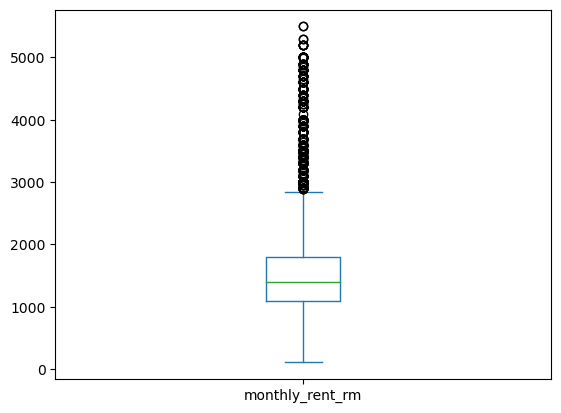

In [39]:
#| label: fig-rent-final
#| fig-cap: "Data after Outlier Removal"
dfx.to_pandas().monthly_rent_rm.plot(kind='box', x='monthly_rent_rm')

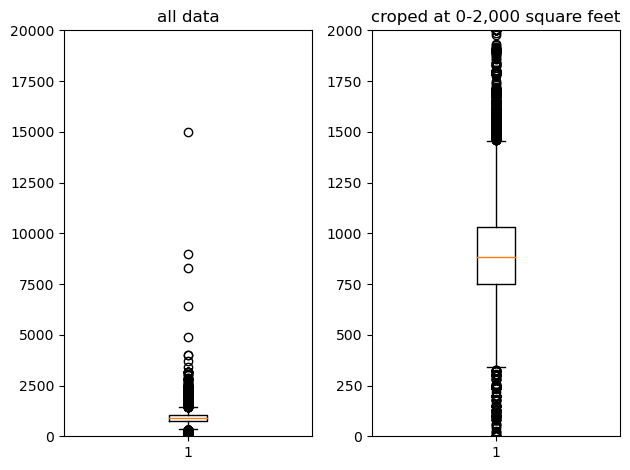

In [40]:
#| label: fig-size-comparison
#| fig-cap: "Raw Data Size sq.ft"
fig, axs = plt.subplots(1,2)
axs[0].boxplot(data=dfx.to_pandas(), x='size_sqft')
axs[0].set_ylim(0,20000)
axs[0].set_title('all data')

axs[1].boxplot(data=dfx.to_pandas(), x='size_sqft')
axs[1].set_ylim(0,2000)
axs[1].set_title('croped at 0-2,000 square feet')

plt.tight_layout()
plt.show()

In [41]:
#removing outliers below 500, and higher than 3000 sqft and below 50 sqft
dfx = dfx.filter((pl.col("size_sqft") > 50) & (pl.col("size_sqft") < 3000))

<Axes: >

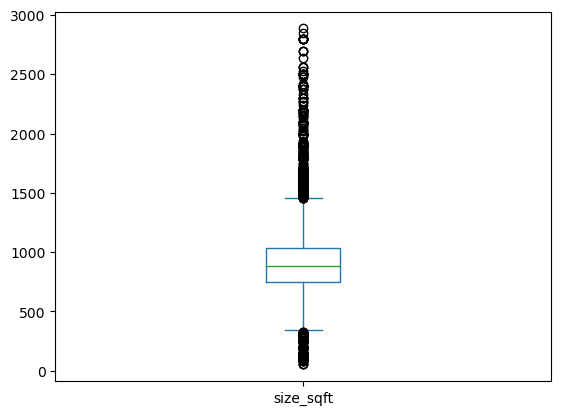

In [42]:
dfx.to_pandas()["size_sqft"].plot(kind='box')

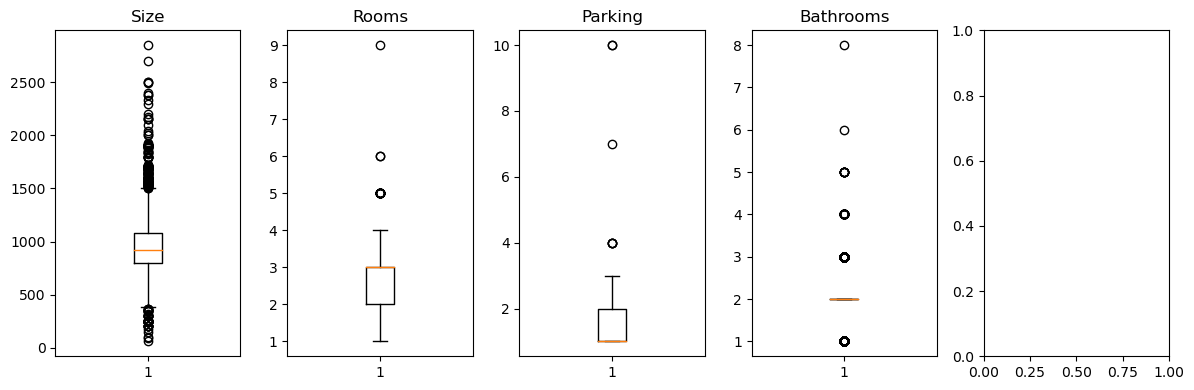

In [43]:
#| label: fig-complete-outliers
#| fig-cap: "Final Data after Outlier Removal"
fig, axs = plt.subplots(1,5, figsize=(12,4))
axs[0].boxplot(data=dfx.to_pandas().dropna(), x='size_sqft')
axs[1].boxplot(data=dfx.to_pandas().dropna(), x='rooms')
axs[2].boxplot(data=dfx.to_pandas().dropna(), x='parking')
axs[3].boxplot(data=dfx.to_pandas().dropna(), x='bathroom')
# axs[4].boxplot(data=dfx.dropna(), x='completion_year')

axs[0].set_title('Size')
axs[1].set_title('Rooms')
axs[2].set_title('Parking')
axs[3].set_title('Bathrooms')
# axs[4].set_title('Completion Year')

plt.tight_layout()
plt.show()

In [44]:
dfx.shape

(19761, 15)

#### Data Preprocessing
##### Input-Output

##### Train-Test Split Data

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
X_train, X_test, y_train, y_test = train_test_split(dfx.drop("monthly_rent_rm").to_pandas(),
                                                    dfx.select(pl.col("monthly_rent_rm")).to_numpy(),
                                                    test_size = 0.2,
                                                    random_state = 123)

In [47]:
len(X_test)/len(dfx.drop("monthly_rent_rm").to_pandas())

0.20004048378118516

In [48]:
X_train

,completion_year,location,property_type,rooms,parking,bathroom,size_sqft,furnished,region,Air-Cond_availability,Washing Machine_availability,Near KTM/LRT_availability,Internet_availability,Cooking Allowed_availability
3850,2019.0,Semenyih,Apartment,3.0,2.0,2.0,1000,Partially Furnished,Selangor,False,True,True,False,False
16305,2021.0,Sentul,Service Residence,3.0,1.0,2.0,850,Not Furnished,Kuala Lumpur,True,False,False,False,True
9873,NaN,Cheras,Apartment,3.0,2.0,2.0,860,Partially Furnished,Kuala Lumpur,None,None,None,None,None
4734,2010.0,Jalan Ipoh,Condominium,3.0,1.0,2.0,1062,Partially Furnished,Kuala Lumpur,None,None,None,None,None
10718,2024.0,Salak Tinggi,Condominium,1.0,1.0,1.0,450,Not Furnished,Selangor,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13435,NaN,Seri Kembangan,Condominium,3.0,2.0,2.0,854,Partially Furnished,Selangor,True,False,False,False,True
7763,2015.0,Setia Alam,Service Residence,1.0,NaN,1.0,486,Fully Furnished,Selangor,None,None,None,None,None
15377,NaN,Puchong,Apartment,3.0,1.0,2.0,850,Fully Furnished,Selangor,True,True,True,False,True
17730,NaN,Serdang,Condominium,3.0,2.0,2.0,1000,Not Furnished,Kuala Lumpur,False,False,True,False,True


##### Preprocessing Original Data for Categorical Dtypes

One must paying attention to the number of categorical observation in the original data, with respect to the sampling train-test value. If, the test_size = 0.3, that means any categorical observation with a total of 3 and less, would not be distributed evenly among train and test data.

In [49]:
print(dfx["location"].n_unique())
print(X_train.location.nunique())
print(X_test.location.nunique())

127
126
113


In [50]:
print(dfx["property_type"].n_unique())
print(X_train.property_type.nunique())
print(X_test.property_type.nunique())

10
9
9


In [51]:
print(set(X_train.furnished.to_list()) - set(X_test.furnished.to_list()))
print(set(X_train.location.to_list()) - set(X_test.location.to_list()))
print(set(X_train.property_type.to_list()) - set(X_test.property_type.to_list()))
print(set(X_train['Air-Cond_availability'].to_list()) - set(X_test['Air-Cond_availability'].to_list()))
print(set(X_train['Washing Machine_availability'].to_list()) - set(X_test['Washing Machine_availability'].to_list()))
print(set(X_train['Internet_availability'].to_list()) - set(X_test['Internet_availability'].to_list()))
print(set(X_train['Cooking Allowed_availability'].to_list()) - set(X_test['Cooking Allowed_availability'].to_list()))
print(set(X_train['Near KTM/LRT_availability'].to_list()) - set(X_test['Near KTM/LRT_availability'].to_list()))

set()
{'Damansara', 'Alam Impian', 'Mutiara Damansara', 'Serdang', 'Bandar Botanic', 'Telok Panglima Garang', 'Chan Sow Lin', '369', 'Bukit Beruntung', 'Sungai Penchala', 'Bukit Tunku', 'Pulau Indah (Pulau Lumut)', 'Puncak Jalil', 'Damansara Jaya'}
{'Condo / Services residence / Penthouse / Townhouse'}
set()
set()
set()
set()
set()


#### 
Dropping Data

In [52]:
dfx["location"].value_counts().sort("counts").head(37)

location,counts
str,u32
"""Damansara Jaya…",1
"""369""",1
"""Puncak Jalil""",1
"""Sungai Penchal…",1
"""Telok Panglima…",1
"""43""",1
"""Pulau Indah (P…",1
"""Chan Sow Lin""",1
"""Bandar Botanic…",1


In [53]:
exclude_location = dfx["location"].value_counts().sort("counts").head(37)["location"].to_numpy()
exclude_location

array(['Pulau Indah (Pulau Lumut)', 'Chan Sow Lin', 'Puncak Jalil',
       'Telok Panglima Garang', 'Bandar Botanic', 'Sungai Penchala',
       'Damansara Jaya', '369', '43', 'Mutiara Damansara', 'Damansara',
       'Bukit Beruntung', 'Bukit Tunku', 'KL Eco City', 'Bukit Subang',
       'Kuala Selangor', 'Saujana Utama', 'Serendah', '517',
       'Hulu Langat', 'Salak Tinggi', 'Bandar Bukit Tinggi', 'KL Sentral',
       'Others', 'Salak Selatan', 'Banting', 'Beranang',
       'Bandar Damai Perdana', 'Jinjang', 'Putra Heights',
       'Mid Valley City', 'Puchong South', 'Bandar Utama', 'Kapar',
       'Serdang', 'Bandar Tasik Selatan', 'Subang Bestari'], dtype=object)

In [54]:
dfx["property_type"].value_counts().sort("property_type")

property_type,counts
str,u32
"""Apartment""",5232
"""Condo / Servic…",1
"""Condominium""",8305
"""Duplex""",72
"""Flat""",577
"""Houses""",1
"""Others""",87
"""Service Reside…",5264
"""Studio""",189


In [55]:
dfx_new = dfx.filter((~pl.col("location").is_in(exclude_location.tolist())))
dfx_new = dfx_new.filter((~pl.col("property_type").is_in(["Condo / Services residence / Penthouse / Townhouse", "Townhouse Condo"])))

In [56]:
dfx_new["property_type"].value_counts()

property_type,counts
str,u32
"""Others""",85
"""Studio""",186
"""Service Reside…",5229
"""Duplex""",72
"""Condominium""",8259
"""Flat""",561
"""Apartment""",5154


In [57]:
dfx_new

completion_year,monthly_rent_rm,location,property_type,rooms,parking,bathroom,size_sqft,furnished,region,Air-Cond_availability,Washing Machine_availability,Near KTM/LRT_availability,Internet_availability,Cooking Allowed_availability
f64,i64,str,str,i64,f64,f64,i64,str,str,bool,bool,bool,bool,bool
null,1100,"""Cyberjaya""","""Service Reside…",3,1.0,2.0,913,"""Partially Furn…","""Selangor""",false,true,false,false,false
null,1000,"""Wangsa Maju""","""Apartment""",2,1.0,1.0,600,"""Not Furnished""","""Kuala Lumpur""",false,false,false,false,true
2017.0,3200,"""Bangsar South""","""Service Reside…",3,1.0,2.0,990,"""Fully Furnishe…","""Kuala Lumpur""",true,true,false,false,true
2014.0,1800,"""Sentul""","""Condominium""",3,1.0,2.0,1100,"""Fully Furnishe…","""Kuala Lumpur""",null,null,null,null,null
2021.0,1300,"""Bukit Jalil""","""Apartment""",3,1.0,2.0,850,"""Partially Furn…","""Kuala Lumpur""",null,null,null,null,null
2007.0,1800,"""Setapak""","""Condominium""",3,1.0,2.0,1076,"""Fully Furnishe…","""Kuala Lumpur""",null,null,null,null,null
null,1400,"""Jalan Kuching""","""Service Reside…",3,1.0,2.0,878,"""Partially Furn…","""Kuala Lumpur""",true,false,false,false,true
2009.0,1400,"""Sentul""","""Condominium""",3,1.0,2.0,900,"""Partially Furn…","""Kuala Lumpur""",null,null,null,null,null
2018.0,1200,"""Shah Alam""","""Service Reside…",1,1.0,1.0,500,"""Fully Furnishe…","""Selangor""",true,true,true,true,true


In [58]:
X_train, X_test, y_train, y_test = train_test_split(dfx_new.drop("monthly_rent_rm").to_pandas(),
                                                    dfx_new.select(pl.col("monthly_rent_rm")).to_numpy(),
                                                    test_size = 0.2,
                                                    random_state = 123)

In [59]:
print(set(X_train.furnished.to_list()) - set(X_test.furnished.to_list()))
print(set(X_train.location.to_list()) - set(X_test.location.to_list()))
print(set(X_train.property_type.to_list()) - set(X_test.property_type.to_list()))

{None}
set()
set()


In [60]:
print(dfx_new["location"].n_unique())
print(X_train.location.nunique())
print(X_test.location.nunique())

90
90
90


##### Training Data Imputation

In [61]:
X_train.isna().sum()

completion_year                 7154
location                           0
property_type                      0
rooms                              3
parking                         4465
bathroom                           1
size_sqft                          0
furnished                          1
region                             0
Air-Cond_availability           4652
Washing Machine_availability    4652
Near KTM/LRT_availability       4652
Internet_availability           4652
Cooking Allowed_availability    4652
dtype: int64

In [62]:
X_train_num = X_train.select_dtypes(exclude='object')

In [63]:
X_train_num.isna().sum()

completion_year    7154
rooms                 3
parking            4465
bathroom              1
size_sqft             0
dtype: int64

##### 
We can fill completion year, rooms, parking and bathroom with mode

In [64]:
from sklearn.impute import SimpleImputer
def numericalImputation(X_train_num, strategy = 'most_frequent'):
    # create imputer
    imputer_num = SimpleImputer(missing_values = np.nan, strategy = strategy)
    
    # fitting
    imputer_num.fit(X_train_num)

    # transform
    imputed_data = imputer_num.transform(X_train_num)
    X_train_num_imputed = pd.DataFrame(imputed_data)

    # making imputated and non-imputated columns are the same
    X_train_num_imputed.columns = X_train_num.columns
    X_train_num_imputed.index = X_train_num.index

    return X_train_num_imputed, imputer_num

In [65]:
def numericalImputationNone(X_train_num, strategy = 'most_frequent'):
    # create imputer
    imputer_num = SimpleImputer(missing_values = None, strategy = strategy)
    
    # fitting
    imputer_num.fit(X_train_num)

    # transform
    imputed_data = imputer_num.transform(X_train_num)
    X_train_num_imputed = pd.DataFrame(imputed_data)

    # making imputated and non-imputated columns are the same
    X_train_num_imputed.columns = X_train_num.columns
    X_train_num_imputed.index = X_train_num.index

    return X_train_num_imputed, imputer_num

In [66]:
X_train_num, imputer_num = numericalImputation(X_train_num, strategy='most_frequent')
X_train_num.isna().sum()

completion_year    0
rooms              0
parking            0
bathroom           0
size_sqft          0
dtype: int64

##### Categorical Data

In [67]:
X_train_cat = X_train.select_dtypes(include='object')

In [68]:
X_train_cat

,location,property_type,furnished,region,Air-Cond_availability,Washing Machine_availability,Near KTM/LRT_availability,Internet_availability,Cooking Allowed_availability
9511,Pantai,Condominium,Fully Furnished,Kuala Lumpur,True,True,True,True,True
17185,Puchong,Condominium,Partially Furnished,Selangor,None,None,None,None,None
8244,Cyberjaya,Apartment,Fully Furnished,Selangor,True,True,False,False,True
1378,Shah Alam,Apartment,Partially Furnished,Selangor,None,None,None,None,None
18411,Taman Desa,Condominium,Fully Furnished,Kuala Lumpur,True,True,False,False,True
...,...,...,...,...,...,...,...,...,...
13435,Damansara Damai,Flat,Not Furnished,Selangor,True,False,True,False,True
7763,Wangsa Maju,Condominium,Not Furnished,Kuala Lumpur,None,None,None,None,None
15377,Desa Pandan,Service Residence,Fully Furnished,Kuala Lumpur,True,False,False,False,True
17730,Jalan Ipoh,Condominium,Partially Furnished,Kuala Lumpur,True,False,True,False,True


In [69]:
X_train_cat.isna().sum()

location                           0
property_type                      0
furnished                          1
region                             0
Air-Cond_availability           4652
Washing Machine_availability    4652
Near KTM/LRT_availability       4652
Internet_availability           4652
Cooking Allowed_availability    4652
dtype: int64

#### 
Impute with mode

In [70]:
X_train_cat, imputer_num = numericalImputationNone(X_train_cat, strategy='most_frequent')
X_train_cat.isna().sum()

location                        0
property_type                   0
furnished                       0
region                          0
Air-Cond_availability           0
Washing Machine_availability    0
Near KTM/LRT_availability       0
Internet_availability           0
Cooking Allowed_availability    0
dtype: int64

In [71]:
imputer_num

SimpleImputer(missing_values=None, strategy='most_frequent')

##### Preprocessing Categorical Variable

In [72]:
X_train_cat_ohe =  pd.get_dummies(X_train_cat)

In [73]:
X_train_cat_ohe

,location_360,location_389,location_639,location_Alam Impian,location_Ampang,location_Ampang Hilir,location_Ara Damansara,location_Balakong,location_Bandar Bukit Raja,location_Bandar Kinrara,...,Air-Cond_availability_False,Air-Cond_availability_True,Washing Machine_availability_False,Washing Machine_availability_True,Near KTM/LRT_availability_False,Near KTM/LRT_availability_True,Internet_availability_False,Internet_availability_True,Cooking Allowed_availability_False,Cooking Allowed_availability_True
9511,False,False,False,False,False,False,False,False,False,False,...,False,True,False,True,False,True,False,True,False,True
17185,False,False,False,False,False,False,False,False,False,False,...,False,True,False,True,False,True,True,False,False,True
8244,False,False,False,False,False,False,False,False,False,False,...,False,True,False,True,True,False,True,False,False,True
1378,False,False,False,False,False,False,False,False,False,False,...,False,True,False,True,False,True,True,False,False,True
18411,False,False,False,False,False,False,False,False,False,False,...,False,True,False,True,True,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13435,False,False,False,False,False,False,False,False,False,False,...,False,True,True,False,False,True,True,False,False,True
7763,False,False,False,False,False,False,False,False,False,False,...,False,True,False,True,False,True,True,False,False,True
15377,False,False,False,False,False,False,False,False,False,False,...,False,True,True,False,True,False,True,False,False,True
17730,False,False,False,False,False,False,False,False,False,False,...,False,True,True,False,False,True,True,False,False,True


In [74]:
ohe_columns = X_train_cat_ohe.columns

In [75]:
X_train_cat_ohe.isna().sum()

location_360                          0
location_389                          0
location_639                          0
location_Alam Impian                  0
location_Ampang                       0
                                     ..
Near KTM/LRT_availability_True        0
Internet_availability_False           0
Internet_availability_True            0
Cooking Allowed_availability_False    0
Cooking Allowed_availability_True     0
Length: 112, dtype: int64

In [76]:
X_train_num.isna().sum()

completion_year    0
rooms              0
parking            0
bathroom           0
size_sqft          0
dtype: int64

##### Combine Numerical dan Categorical data

In [77]:
X_train_concat = pd.concat([X_train_num, X_train_cat_ohe], axis = 1)

In [78]:
X_train_concat

,completion_year,rooms,parking,bathroom,size_sqft,location_360,location_389,location_639,location_Alam Impian,location_Ampang,...,Air-Cond_availability_False,Air-Cond_availability_True,Washing Machine_availability_False,Washing Machine_availability_True,Near KTM/LRT_availability_False,Near KTM/LRT_availability_True,Internet_availability_False,Internet_availability_True,Cooking Allowed_availability_False,Cooking Allowed_availability_True
9511,2019.0,3.0,2.0,3.0,1360.0,False,False,False,False,False,...,False,True,False,True,False,True,False,True,False,True
17185,2021.0,4.0,2.0,2.0,1055.0,False,False,False,False,False,...,False,True,False,True,False,True,True,False,False,True
8244,2018.0,2.0,2.0,2.0,900.0,False,False,False,False,False,...,False,True,False,True,True,False,True,False,False,True
1378,2021.0,3.0,1.0,2.0,815.0,False,False,False,False,False,...,False,True,False,True,False,True,True,False,False,True
18411,1988.0,3.0,2.0,2.0,1200.0,False,False,False,False,False,...,False,True,False,True,True,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13435,2021.0,3.0,2.0,2.0,650.0,False,False,False,False,False,...,False,True,True,False,False,True,True,False,False,True
7763,2021.0,4.0,2.0,2.0,1784.0,False,False,False,False,False,...,False,True,False,True,False,True,True,False,False,True
15377,2021.0,2.0,2.0,2.0,950.0,False,False,False,False,False,...,False,True,True,False,True,False,True,False,False,True
17730,2009.0,2.0,1.0,2.0,840.0,False,False,False,False,False,...,False,True,True,False,False,True,True,False,False,True


In [79]:
X_train_concat.isnull().sum()

completion_year                       0
rooms                                 0
parking                               0
bathroom                              0
size_sqft                             0
                                     ..
Near KTM/LRT_availability_True        0
Internet_availability_False           0
Internet_availability_True            0
Cooking Allowed_availability_False    0
Cooking Allowed_availability_True     0
Length: 117, dtype: int64

#### Standardization

In [80]:
from sklearn.preprocessing import StandardScaler
def standardizerData(data):
    data_columns = data.columns  #preserve columns
    data_index = data.index  #preserve index

    # create and fit standardizer
    standardizer = StandardScaler()
    standardizer.fit(data)

    # transform data
    standardized_data_raw = standardizer.transform(data)
    standardized_data = pd.DataFrame(standardized_data_raw)
    standardized_data.columns = data_columns
    standardized_data.index = data_index

    return standardized_data, standardizer

In [81]:
X_train_clean, standardizer = standardizerData(data = X_train_concat)

In [82]:
X_train_clean

,completion_year,rooms,parking,bathroom,size_sqft,location_360,location_389,location_639,location_Alam Impian,location_Ampang,...,Air-Cond_availability_False,Air-Cond_availability_True,Washing Machine_availability_False,Washing Machine_availability_True,Near KTM/LRT_availability_False,Near KTM/LRT_availability_True,Internet_availability_False,Internet_availability_True,Cooking Allowed_availability_False,Cooking Allowed_availability_True
9511,0.230485,0.415338,1.414447,2.202709,1.666880,-0.052513,-0.043106,-0.025297,-0.035787,-0.182502,...,-0.436045,0.436045,-0.696145,0.696145,-0.698982,0.698982,-2.655465,2.655465,-0.251762,0.251762
17185,0.570327,1.672934,1.414447,0.238772,0.548357,-0.052513,-0.043106,-0.025297,-0.035787,-0.182502,...,-0.436045,0.436045,-0.696145,0.696145,-0.698982,0.698982,0.376582,-0.376582,-0.251762,0.251762
8244,0.060563,-0.842258,1.414447,0.238772,-0.020073,-0.052513,-0.043106,-0.025297,-0.035787,-0.182502,...,-0.436045,0.436045,-0.696145,0.696145,1.430652,-1.430652,0.376582,-0.376582,-0.251762,0.251762
1378,0.570327,0.415338,-0.584495,0.238772,-0.331793,-0.052513,-0.043106,-0.025297,-0.035787,-0.182502,...,-0.436045,0.436045,-0.696145,0.696145,-0.698982,0.698982,0.376582,-0.376582,-0.251762,0.251762
18411,-5.037069,0.415338,1.414447,0.238772,1.080114,-0.052513,-0.043106,-0.025297,-0.035787,-0.182502,...,-0.436045,0.436045,-0.696145,0.696145,1.430652,-1.430652,0.376582,-0.376582,-0.251762,0.251762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13435,0.570327,0.415338,1.414447,0.238772,-0.936895,-0.052513,-0.043106,-0.025297,-0.035787,-0.182502,...,-0.436045,0.436045,1.436482,-1.436482,-0.698982,0.698982,0.376582,-0.376582,-0.251762,0.251762
7763,0.570327,1.672934,1.414447,0.238772,3.221810,-0.052513,-0.043106,-0.025297,-0.035787,-0.182502,...,-0.436045,0.436045,-0.696145,0.696145,-0.698982,0.698982,0.376582,-0.376582,-0.251762,0.251762
15377,0.570327,-0.842258,1.414447,0.238772,0.163291,-0.052513,-0.043106,-0.025297,-0.035787,-0.182502,...,-0.436045,0.436045,1.436482,-1.436482,1.430652,-1.430652,0.376582,-0.376582,-0.251762,0.251762
17730,-1.468726,-0.842258,-0.584495,0.238772,-0.240110,-0.052513,-0.043106,-0.025297,-0.035787,-0.182502,...,-0.436045,0.436045,1.436482,-1.436482,-0.698982,0.698982,0.376582,-0.376582,-0.251762,0.251762


##### Training Machine Learning
Since this is a regression model, R2 score and mean absolute error (MAE) will be used as a performance metrics.

The machine learning model will use baseline from average value of the target columns (monthly rent) and also result from linear regression model. After that, author used some of the recommended model based on previous works, which are random forest and gradient boosting to better improve the performance of the model.

##### Baseline-Average Value
The concept here is to use average value of the target as the easiest way to predict the monhtly rent of a unit.

In [83]:
y_baseline = np.ones(len(y_train)) * y_train.mean()
y_baseline

array([1563.6696086, 1563.6696086, 1563.6696086, ..., 1563.6696086,
       1563.6696086, 1563.6696086])

In [84]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Train the linear regression model
lin_reg = LinearRegression().fit(X_train_clean, y_train)

# Predict using the train data
y_pred_train = y_baseline

# Calculate R-squared
r2_baseline = r2_score(y_train, y_pred_train)

# Calculate MAE
mae_baseline = mean_absolute_error(y_train, y_pred_train)

print(f"R2-score: {r2_baseline:.4f} and MAE score: {mae_baseline:.4f}")

R2-score: 0.0000 and MAE score: 513.2078


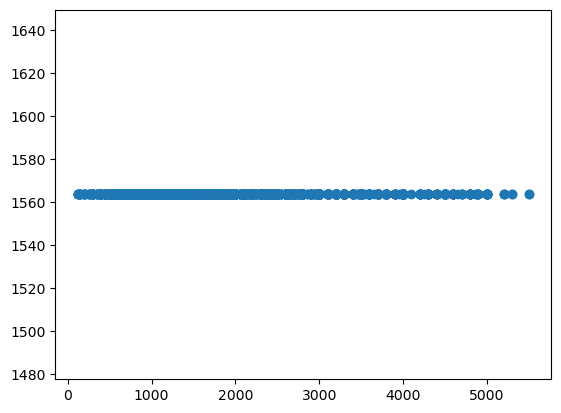

In [85]:
plt.scatter(x=y_train, y=y_pred_train);

##### Baseline-Linear Regression
The second method is using linear regression, which simply put is finding the minum total error (distance) between predicted value and the target value, using linear equation.

In [86]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Train the linear regression model
lin_reg = LinearRegression().fit(X_train_clean, y_train)

# Predict using the train data
# y_pred = y_baseline
y_pred_train = lin_reg.predict(X_train_clean)

# Calculate mean absolute error
mae_linreg = mean_absolute_error(y_train, y_pred_train)

# Calculate R-squared
r2_linreg = r2_score(y_train, y_pred_train)

print(f"R2-score: {r2_linreg:.4f} and MAE score: {mae_linreg:.4f}")

R2-score: 0.6706 and MAE score: 281.7165


In [87]:
y_train.flatten()

array([4000, 1200, 1800, ..., 2400, 1400, 1100])

In [88]:
y_pred_train.shape

(15636, 1)

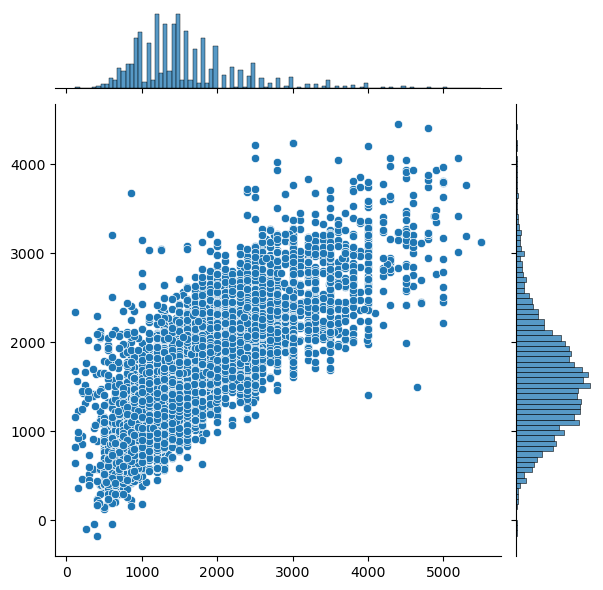

In [89]:
sns.jointplot(x=y_train.flatten(), y=y_pred_train.flatten());

In [90]:
from sklearn.svm import SVR
#from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Train the support vector machine model
svr_reg = SVR(kernel="linear")
svr_reg.fit(X_train_clean, y_train.flatten())

# Predict using the train data
y_pred_train = svr_reg.predict(X_train_clean)

# Calculate R-squared
r2_svr = r2_score(y_train, y_pred_train)

# Calculate MAE
mae_svr = mean_absolute_error(y_train, y_pred_train)

print(f"R2-score: {r2_svr:.4f} and MAE score: {mae_svr:.4f}")

R2-score: 0.6490 and MAE score: 273.3103


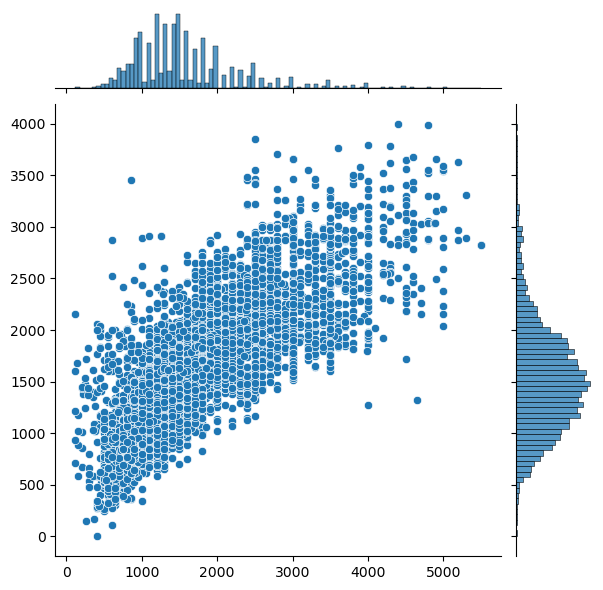

In [91]:
sns.jointplot(x=y_train.flatten(), y=y_pred_train.flatten());

In [92]:
# GridSearch

from sklearn.model_selection import GridSearchCV 

params = {'kernel': ['linear', 'poly', 'rbf']} 

# Create gridsearch
svr_reg_cv = GridSearchCV(estimator = SVR(), param_grid = params, refit = True, verbose = 3)

In [93]:
# Fit GridSearchCV
svr_reg_cv.fit(X_train_clean, y_train.flatten())

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END .....................kernel=linear;, score=0.640 total time=   7.5s
[CV 2/5] END .....................kernel=linear;, score=0.630 total time=   6.8s
[CV 3/5] END .....................kernel=linear;, score=0.668 total time=   6.9s
[CV 4/5] END .....................kernel=linear;, score=0.637 total time=   8.2s
[CV 5/5] END .....................kernel=linear;, score=0.647 total time=   9.4s
[CV 1/5] END .......................kernel=poly;, score=0.039 total time=   7.3s
[CV 2/5] END .......................kernel=poly;, score=0.039 total time=   7.3s
[CV 3/5] END .......................kernel=poly;, score=0.057 total time=   7.2s
[CV 4/5] END .......................kernel=poly;, score=0.043 total time=   6.8s
[CV 5/5] END .......................kernel=poly;, score=0.055 total time=   7.1s
[CV 1/5] END ........................kernel=rbf;, score=0.143 total time=   9.3s
[CV 2/5] END ........................kernel=rbf;,

GridSearchCV(estimator=SVR(), param_grid={'kernel': ['linear', 'poly', 'rbf']},
             verbose=3)

In [94]:
svr_reg_cv.best_params_

{'kernel': 'linear'}

In [95]:
svr_reg_cv.best_estimator_

SVR(kernel='linear')

In [96]:
svr_reg = SVR(kernel = svr_reg_cv.best_params_['kernel']) 

In [97]:
# Refit the Support Vector Regression
svr_reg.fit(X_train_clean, y_train.flatten())

# Predict using the train data
y_pred_train = svr_reg.predict(X_train_clean)

# Calculate R-squared
r2_svr_cv = r2_score(y_train, y_pred_train)

# Calculate MAE
mae_svr_cv = mean_absolute_error(y_train, y_pred_train)

print(f"R2-score: {r2_svr_cv:.4f} and MAE score: {mae_svr_cv:.4f}")

R2-score: 0.6490 and MAE score: 273.3103


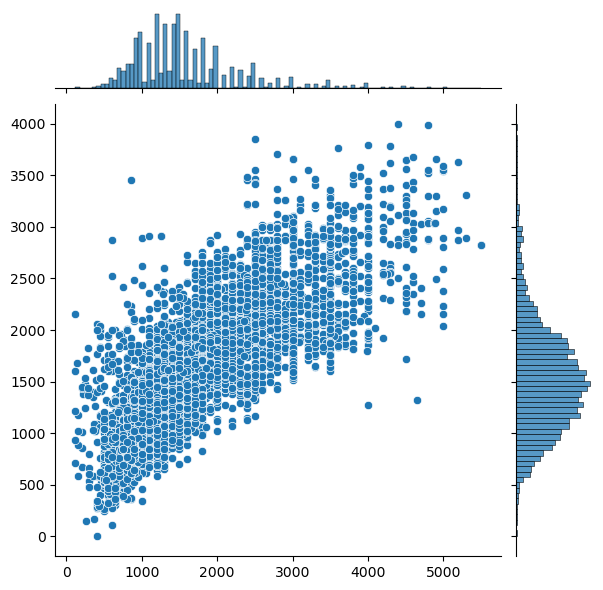

In [98]:
sns.jointplot(x=y_train.flatten(), y=y_pred_train.flatten());

##### GradientBoosting
The gradient boosting, is one of the recommendation from previous works, is a model where each sample would be given a different weights (boosts) depending on its performance in predicting the value/ target.

In [99]:
from sklearn.ensemble import GradientBoostingRegressor
# Build random forest
grad_tree = GradientBoostingRegressor(random_state = 123)

In [100]:
# Fit random forest
grad_tree.fit(X_train_clean, y_train.flatten())

GradientBoostingRegressor(random_state=123)

In [101]:
# Predict
y_pred_train = grad_tree.predict(X_train_clean)
# y_pred_test = grad_tree.predict(X_test_clean)

# Calculate mean absolute error
mae_gb = mean_absolute_error(y_train, y_pred_train)

# Calculate R-squared
r2_gb = r2_score(y_train, y_pred_train)

print(f"R2-score: {r2_gb:.4f} and MAE score: {mae_gb:.4f}")

R2-score: 0.6993 and MAE score: 267.1219


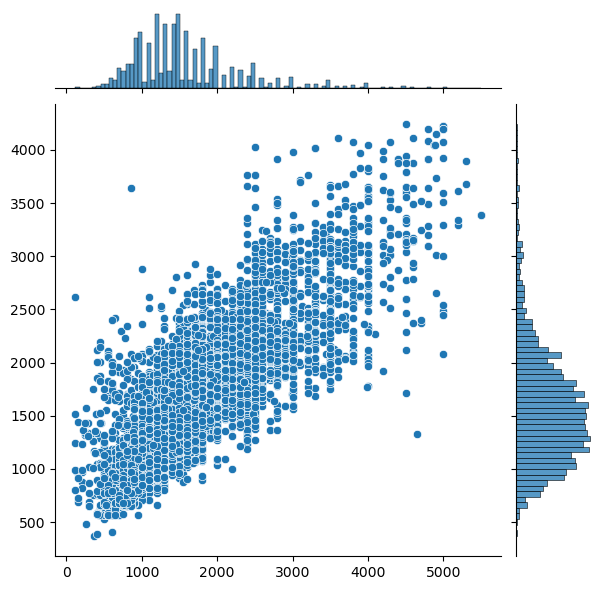

In [102]:
sns.jointplot(x=y_train.flatten(), y=y_pred_train.flatten());

In [103]:
# GridSearch

#from sklearn.model_selection import GridSearchCV 


params = {'n_estimators': [100, 200, 300, 400, 500],
              'learning_rate': [0.1, 0.05, 0.01]}

# Create gridsearch
grad_tree = GradientBoostingRegressor(random_state = 123)

grad_tree_cv = GridSearchCV(estimator = grad_tree,
                           param_grid = params,
                           cv = 5,
                           scoring = "neg_mean_absolute_error")

In [104]:
# Fit GridSearchCV
grad_tree_cv.fit(X_train_clean, y_train.flatten())

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=123),
             param_grid={'learning_rate': [0.1, 0.05, 0.01],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring='neg_mean_absolute_error')

In [105]:
grad_tree_cv.best_params_

{'learning_rate': 0.1, 'n_estimators': 500}

In [106]:
# Refit the Adaboost
grad_tree = GradientBoostingRegressor(n_estimators = grad_tree_cv.best_params_["n_estimators"],
                                      random_state = 123)

grad_tree.fit(X_train_clean, y_train.flatten())

GradientBoostingRegressor(n_estimators=500, random_state=123)

In [107]:
# Predict
y_pred_train = grad_tree.predict(X_train_clean)

# Calculate mean absolute error
mae_gb_cv = mean_absolute_error(y_train, y_pred_train)

# Calculate R-squared
r2_gb_cv = r2_score(y_train, y_pred_train)

print(f"R2-score: {r2_gb_cv:.4f} and MAE score: {mae_gb_cv:.4f}")

R2-score: 0.7948 and MAE score: 222.5448


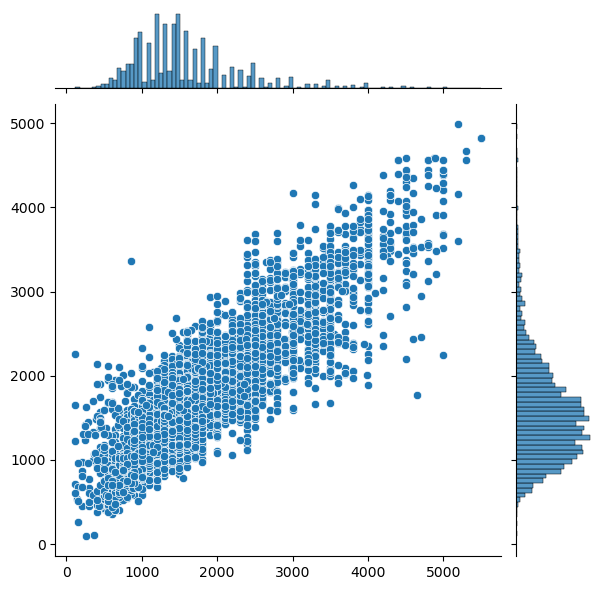

In [108]:
sns.jointplot(x=y_train.flatten(), y=y_pred_train.flatten())

##### Random Forest
The last model, which was also recommended by previous works, is a model where not only it has weights based on its performance, but the feature selection in which the sample is measured was done at random. Therefore, reduces not only the variance, but also the bias.

In [109]:
from sklearn.ensemble import RandomForestRegressor

In [110]:
# Build random forest
rf_tree = RandomForestRegressor(n_estimators = 100,
                                criterion = "squared_error",
                                max_features = "sqrt",
                                random_state = 123)

In [111]:
# Fit random forest
rf_tree.fit(X_train_clean, y_train.flatten())

RandomForestRegressor(max_features='sqrt', random_state=123)

In [112]:
# Predict
y_pred_train = rf_tree.predict(X_train_clean)

# Calculate mean absolute error
mae_rf = mean_absolute_error(y_train, y_pred_train)

# Calculate R-squared
r2_rf = r2_score(y_train, y_pred_train)

print(f"R2-score: {r2_rf:.4f} and MAE score: {mae_rf:.4f}")

R2-score: 0.9644 and MAE score: 83.1860


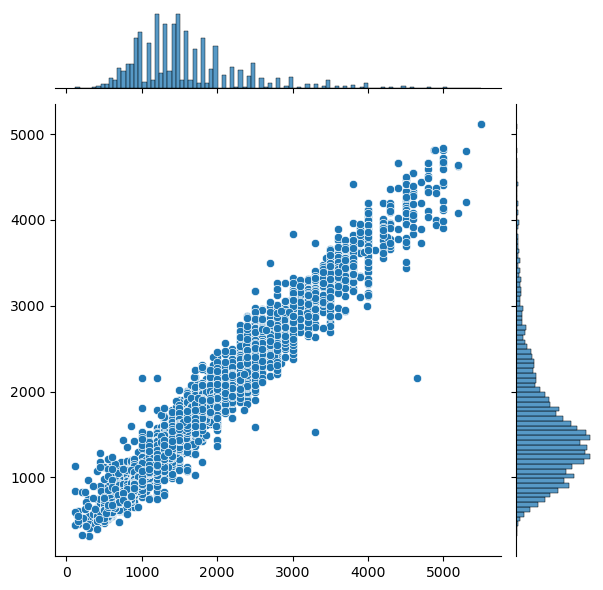

In [113]:
sns.jointplot(x=y_train.flatten(), y=y_pred_train.flatten())

In [114]:
params = {"n_estimators": [100, 200, 300, 500 ],
          "max_features": ["sqrt", "log2"]}

# Create GridSearch
rf_tree = RandomForestRegressor(criterion = "squared_error",
                                random_state = 123)

rf_tree_cv = GridSearchCV(estimator = rf_tree,
                          param_grid = params,
                          cv = 5,
                          scoring = "neg_mean_absolute_error")

In [115]:
# Fit grid search cv
rf_tree_cv.fit(X_train_clean, y_train.flatten())

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=123),
             param_grid={'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 500]},
             scoring='neg_mean_absolute_error')

In [116]:
# Best params
rf_tree_cv.best_params_

{'max_features': 'sqrt', 'n_estimators': 500}

In [117]:
# Refit the Random Forest
rf_tree = RandomForestRegressor(criterion = "squared_error",
                                max_features = rf_tree_cv.best_params_["max_features"],
                                n_estimators = rf_tree_cv.best_params_["n_estimators"],
                                random_state = 123)

rf_tree.fit(X_train_clean, y_train.flatten())

RandomForestRegressor(max_features='sqrt', n_estimators=500, random_state=123)

In [118]:
# Predict
y_pred_train = rf_tree.predict(X_train_clean)

# Calculate mean absolute error
mae_rf_cv = mean_absolute_error(y_train, y_pred_train)

# # Calculate R-squared
r2_rf_cv = r2_score(y_train, y_pred_train)

print(f"R2-score: {r2_rf_cv:.4f} and MAE score: {mae_rf_cv:.4f}")

R2-score: 0.9656 and MAE score: 82.3544


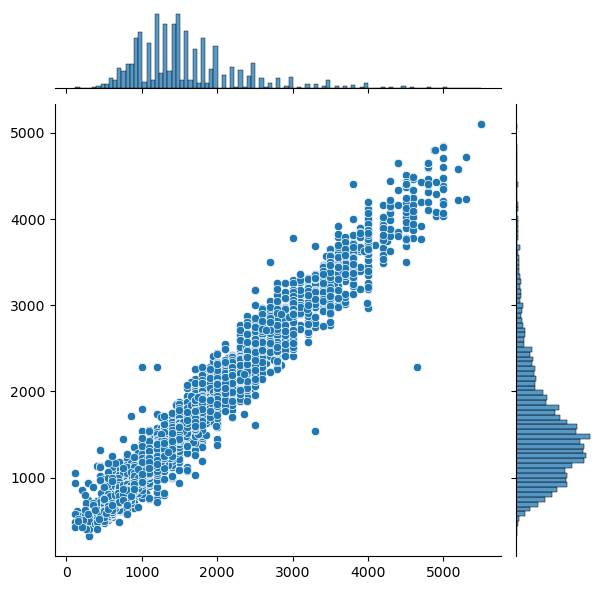

In [119]:
sns.jointplot(x=y_train.flatten(), y=y_pred_train.flatten())

In [120]:
mae_score = [mae_baseline, mae_linreg, mae_svr, mae_svr_cv, mae_gb, mae_gb_cv, mae_rf, mae_rf_cv]
r2_score = [r2_baseline, r2_linreg, r2_svr, r2_svr_cv, r2_gb, r2_gb_cv, r2_rf, r2_rf_cv]
indexes = ["baseline", "linear regression", "support vector regreession", "support vector regreession with CV", "gradient boosting", "gradient boosting with CV", "random forest",  "random forest with CV"]

summary_df = pd.DataFrame({
    "MAE Train": mae_score,
    "R2-Score": r2_score,
},index = indexes)

summary_df.sort_values(by='R2-Score', ascending=False)

,MAE Train,R2-Score
random forest with CV,82.354414,0.965563
random forest,83.185982,0.964449
gradient boosting with CV,222.544772,0.794847
gradient boosting,267.121902,0.699280
linear regression,281.716490,0.670560
support vector regreession,273.310350,0.648962
support vector regreession with CV,273.310350,0.648962
baseline,513.207840,0.000000


#### 
From the above table, it can be seen that Random Forest model performs the best, and Gradient Boosting at the second place. This is similar to the previous work done by others, on house pricing.

##### Best Model

R2-score: 0.966 and MAE score: +/-82.35 RM


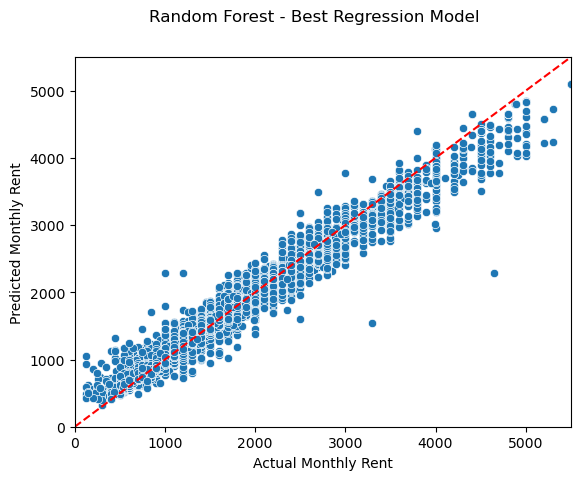

In [121]:
# Libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


# Setting up
rf_tree = RandomForestRegressor(n_estimators = 500,
                                criterion = "squared_error",
                                max_features = "sqrt",
                                random_state = 123)

# Fit model train
rf_tree.fit(X_train_clean, y_train.flatten())

# Predict model train
y_pred_train = rf_tree.predict(X_train_clean)

# Calculate mean absolute error
mae_rf_cv_train = mean_absolute_error(y_train, y_pred_train)

# Calculate R-squared
r2_rf_cv_train = r2_score(y_train, y_pred_train)

print(f"R2-score: {r2_rf_cv_train:.3f} and MAE score: +/-{mae_rf_cv_train:.2f} RM")

sns.scatterplot(x=y_train.flatten(), y=y_pred_train.flatten() )
plt.plot([0, 5500], [0,5500], "--r")
plt.xlim(0, 5500)
plt.xlabel("Actual Monthly Rent")
plt.ylim(0,5500)
plt.ylabel("Predicted Monthly Rent")
plt.suptitle("Random Forest - Best Regression Model")
plt.show()

### Data Prediction

##### Test Data Preprocessing
Simlar process done in train dataset need to be repeated on test dataset.

In [122]:
# Checking null data
X_test.isna().sum()

completion_year                 1773
location                           0
property_type                      0
rooms                              0
parking                         1095
bathroom                           0
size_sqft                          0
furnished                          0
region                             0
Air-Cond_availability           1143
Washing Machine_availability    1143
Near KTM/LRT_availability       1143
Internet_availability           1143
Cooking Allowed_availability    1143
dtype: int64

In [123]:
X_test_num =  X_test.select_dtypes(exclude='object')
X_test_num

,completion_year,rooms,parking,bathroom,size_sqft
10078,2014.0,3.0,1.0,2.0,1012
12096,2020.0,3.0,2.0,2.0,1083
17896,NaN,4.0,NaN,2.0,900
18764,2018.0,1.0,NaN,1.0,684
601,2007.0,3.0,1.0,2.0,810
...,...,...,...,...,...
7741,NaN,3.0,2.0,2.0,1100
5937,2015.0,2.0,2.0,2.0,833
14004,NaN,3.0,NaN,2.0,860
11315,2020.0,3.0,2.0,2.0,1023


In [124]:
X_test_num.isna().sum()

completion_year    1773
rooms                 0
parking            1095
bathroom              0
size_sqft             0
dtype: int64

In [125]:
X_test_num, imputer_num = numericalImputation(X_test_num, strategy='most_frequent')
X_test_num.isna().sum()

completion_year    0
rooms              0
parking            0
bathroom           0
size_sqft          0
dtype: int64

##### Categorical Data

In [126]:
X_test_cat = X_test.select_dtypes(include='object')
X_test_cat

,location,property_type,furnished,region,Air-Cond_availability,Washing Machine_availability,Near KTM/LRT_availability,Internet_availability,Cooking Allowed_availability
10078,Batu Caves,Service Residence,Not Furnished,Selangor,True,True,False,False,True
12096,Kajang,Condominium,Partially Furnished,Selangor,True,False,False,False,True
17896,KLCC,Apartment,Fully Furnished,Kuala Lumpur,False,False,True,False,True
18764,Ampang,Service Residence,Fully Furnished,Kuala Lumpur,True,True,True,False,True
601,Cheras,Condominium,Partially Furnished,Kuala Lumpur,True,True,False,False,True
...,...,...,...,...,...,...,...,...,...
7741,Sungai Buloh,Condominium,Fully Furnished,Selangor,True,True,True,True,True
5937,Cheras,Condominium,Fully Furnished,Kuala Lumpur,None,None,None,None,None
14004,Klang,Apartment,Not Furnished,Selangor,None,None,None,None,None
11315,Bukit Jalil,Condominium,Fully Furnished,Kuala Lumpur,True,True,True,True,True


In [127]:
X_test_cat.isna().sum()

location                           0
property_type                      0
furnished                          0
region                             0
Air-Cond_availability           1143
Washing Machine_availability    1143
Near KTM/LRT_availability       1143
Internet_availability           1143
Cooking Allowed_availability    1143
dtype: int64

In [128]:
X_test_cat, imputer_num = numericalImputationNone(X_test_cat, strategy='most_frequent')
X_test_cat.isna().sum()

location                        0
property_type                   0
furnished                       0
region                          0
Air-Cond_availability           0
Washing Machine_availability    0
Near KTM/LRT_availability       0
Internet_availability           0
Cooking Allowed_availability    0
dtype: int64

#### Categorical OHE

In [129]:
X_test_cat_ohe =  pd.get_dummies(X_test_cat)
X_test_cat_ohe.head(2)

,location_360,location_389,location_639,location_Alam Impian,location_Ampang,location_Ampang Hilir,location_Ara Damansara,location_Balakong,location_Bandar Bukit Raja,location_Bandar Kinrara,...,Air-Cond_availability_False,Air-Cond_availability_True,Washing Machine_availability_False,Washing Machine_availability_True,Near KTM/LRT_availability_False,Near KTM/LRT_availability_True,Internet_availability_False,Internet_availability_True,Cooking Allowed_availability_False,Cooking Allowed_availability_True
10078,False,False,False,False,False,False,False,False,False,False,...,False,True,False,True,True,False,True,False,False,True
12096,False,False,False,False,False,False,False,False,False,False,...,False,True,True,False,True,False,True,False,False,True


In [130]:
ohe_columns = X_test_cat_ohe.columns
ohe_columns

Index(['location_360', 'location_389', 'location_639', 'location_Alam Impian',
       'location_Ampang', 'location_Ampang Hilir', 'location_Ara Damansara',
       'location_Balakong', 'location_Bandar Bukit Raja',
       'location_Bandar Kinrara',
       ...
       'Air-Cond_availability_False', 'Air-Cond_availability_True',
       'Washing Machine_availability_False',
       'Washing Machine_availability_True', 'Near KTM/LRT_availability_False',
       'Near KTM/LRT_availability_True', 'Internet_availability_False',
       'Internet_availability_True', 'Cooking Allowed_availability_False',
       'Cooking Allowed_availability_True'],
      dtype='object', length=112)

In [131]:
X_test_concat = pd.concat([X_test_num,
                            X_test_cat_ohe],
                           axis = 1)

In [132]:
X_test_concat.head(2)

,completion_year,rooms,parking,bathroom,size_sqft,location_360,location_389,location_639,location_Alam Impian,location_Ampang,...,Air-Cond_availability_False,Air-Cond_availability_True,Washing Machine_availability_False,Washing Machine_availability_True,Near KTM/LRT_availability_False,Near KTM/LRT_availability_True,Internet_availability_False,Internet_availability_True,Cooking Allowed_availability_False,Cooking Allowed_availability_True
10078,2014.0,3.0,1.0,2.0,1012.0,False,False,False,False,False,...,False,True,False,True,True,False,True,False,False,True
12096,2020.0,3.0,2.0,2.0,1083.0,False,False,False,False,False,...,False,True,True,False,True,False,True,False,False,True


In [133]:
#sanity check
X_test_concat.isnull().sum()

completion_year                       0
rooms                                 0
parking                               0
bathroom                              0
size_sqft                             0
                                     ..
Near KTM/LRT_availability_True        0
Internet_availability_False           0
Internet_availability_True            0
Cooking Allowed_availability_False    0
Cooking Allowed_availability_True     0
Length: 117, dtype: int64

##### Standardization

In [134]:
from sklearn.preprocessing import StandardScaler
def standardizerData(data):
    data_columns = data.columns  # agar nama kolom tidak hilang
    data_index = data.index  # agar index tidak hilang

    # create and fit standardizer
    standardizer = StandardScaler()
    standardizer.fit(data)

    # transform data
    standardized_data_raw = standardizer.transform(data)
    standardized_data = pd.DataFrame(standardized_data_raw)
    standardized_data.columns = data_columns
    standardized_data.index = data_index

    return standardized_data, standardizer

In [135]:
X_test_clean, standardizer = standardizerData(data = X_test_concat)

In [136]:
X_test_clean.head()

,completion_year,rooms,parking,bathroom,size_sqft,location_360,location_389,location_639,location_Alam Impian,location_Ampang,...,Air-Cond_availability_False,Air-Cond_availability_True,Washing Machine_availability_False,Washing Machine_availability_True,Near KTM/LRT_availability_False,Near KTM/LRT_availability_True,Internet_availability_False,Internet_availability_True,Cooking Allowed_availability_False,Cooking Allowed_availability_True
10078,-0.661453,0.408849,-0.569968,0.256143,0.387223,-0.045279,-0.064101,-0.035783,-0.032001,-0.196246,...,-0.455151,0.455151,-0.706158,0.706158,1.446843,-1.446843,0.378075,-0.378075,-0.256858,0.256858
12096,0.400384,0.408849,1.369609,0.256143,0.639548,-0.045279,-0.064101,-0.035783,-0.032001,-0.196246,...,-0.455151,0.455151,1.416115,-1.416115,1.446843,-1.446843,0.378075,-0.378075,-0.256858,0.256858
17896,0.577357,1.662653,-0.569968,0.256143,-0.010811,-0.045279,-0.064101,-0.035783,-0.032001,-0.196246,...,2.197072,-2.197072,1.416115,-1.416115,-0.691160,0.691160,0.378075,-0.378075,-0.256858,0.256858
18764,0.046438,-2.098759,-0.569968,-1.684787,-0.778447,-0.045279,-0.064101,-0.035783,-0.032001,5.095637,...,-0.455151,0.455151,-0.706158,0.706158,-0.691160,0.691160,0.378075,-0.378075,-0.256858,0.256858
601,-1.900263,0.408849,-0.569968,0.256143,-0.330659,-0.045279,-0.064101,-0.035783,-0.032001,-0.196246,...,-0.455151,0.455151,-0.706158,0.706158,1.446843,-1.446843,0.378075,-0.378075,-0.256858,0.256858


##### Test Data Result

R2-score: 0.806 and MAE score: +/-197.82 RM


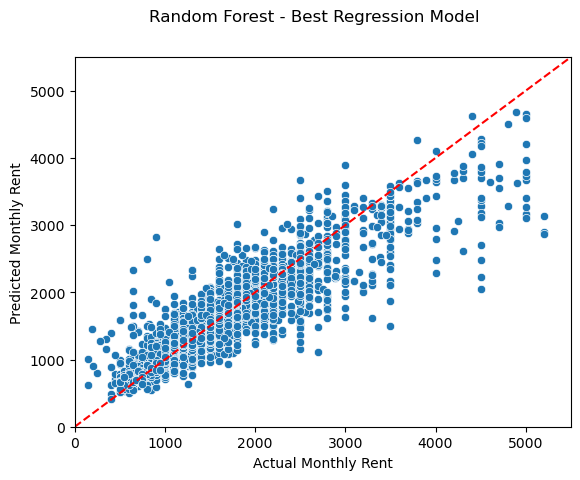

In [137]:
# libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


#setting up
rf_tree = RandomForestRegressor(n_estimators = 500,
                                criterion = "squared_error",
                                max_features = "sqrt",
                                random_state = 123)

#fit model train
rf_tree.fit(X_train_clean, y_train.flatten())

# Predict model
y_pred_test = rf_tree.predict(X_test_clean)

# Calculate mean absolute error
mae_rf_cv_test = mean_absolute_error(y_test, y_pred_test)

# # Calculate R-squared
r2_rf_cv_test = r2_score(y_test, y_pred_test)

print(f"R2-score: {r2_rf_cv_test:.3f} and MAE score: +/-{mae_rf_cv_test:.2f} RM")

sns.scatterplot(x=y_test.flatten(), y=y_pred_test.flatten())
plt.plot([0, 5500], [0,5500], "--r")
plt.xlim(0, 5500)
plt.xlabel("Actual Monthly Rent")
plt.ylim(0,5500)
plt.ylabel("Predicted Monthly Rent")
plt.suptitle("Random Forest - Best Regression Model")
plt.show()

In [138]:
mae_score = [mae_rf_cv_train, mae_rf_cv_test]
r2_score = [r2_rf_cv_train, r2_rf_cv_test]
indexes = ["train", "test"]

summary_df_train_test = pd.DataFrame({
    "MAE Train": mae_score,
    "R2-Score": r2_score,
},index = indexes)

summary_df_train_test

,MAE Train,R2-Score
train,82.354414,0.965563
test,197.820143,0.806166


##### Feature Importance

In [139]:
# calculate the feature importances
importances = rf_tree.feature_importances_

# rescale the importances back to the original scale of the features
importances = importances * X_train_clean.std()

# sort the feature importances in descending order
sorted_index = importances.argsort()[::-1]

# print the feature importances
dict_feature_importance = {}
for i in sorted_index:
    # print("{}: {}".format(X_train_clean.columns[i], importances[i]))
    dict_feature_importance.update({X_train_clean.columns[i]: importances[i]})
    
# Create a DataFrame from the dictionary
df = pd.DataFrame.from_dict(dict_feature_importance, orient='index', columns=['values'])

# Reset the index to become a column
df = df.reset_index()

# Rename the columns
df.columns = ['feature', 'importance_value']

df.sort_values(by='importance_value', ascending=False).head(10)

,feature,importance_value
0,size_sqft,0.186716
1,furnished_Fully Furnished,0.089394
2,completion_year,0.059191
3,bathroom,0.050846
4,rooms,0.046120
5,property_type_Apartment,0.043215
6,furnished_Not Furnished,0.039254
7,parking,0.033066
8,region_Kuala Lumpur,0.029814
9,region_Selangor,0.028958


##### Results
Result indicates that the best model for prediction is Random Forest with hyperparameter tuning, scoring 95% on R2-score, and a shy 100 RM on MAE. This proves to be a good model since the test dataset gives a scoring of 80% on R2, and 240 RM on MAE.

There are some factors that author believed to be affecting the result/ performance of the model:

Dropping missing value reduces the performance! Initial model uses half of the data (4-5k rows) and gives poorer performance on R2 and MAE. Imputation and keeping the number of rows close to the original dataset (9k rows) proves to be improving the model. Especially on test dataset.
Feature selection importance can be seen on the last table, but initially the selection was based on paper and intuition of the author (author lives and work in KL, Malaysia for 5 years). Feature such as completion_year and nearby_railways are important in improving the model.
Last but not least is the outlier identification. The best practice for me is using jointplot to see not only the distribution of the data in 2-dimension, but also in the third dimension (the density) of the data.
Some of the feature that were believed to be quite important even before doing the modeling is size, furnished and location. All three is available within the 10-most features affecting the modeling. As a context, location in KLCC is like Pondok Indah in South Jakarta. Location in Kiara is like BSD in South Tangerang.

#### Discussions
One of the feature that author thinks is significant but not appearing on the 10-best important feature is nearby_railways. This column is showing if a certain property has a close proximity to a railways (KTM/LRT). The issue is, half of the data is missing, hence the imputation. Author belives, the proximity to nearby railways line can be approximated using manhanttan distance of railways line to each property unit.